<h2>Summary</h2>
    <p>This project uses LSTM to predict Apple stock price which was retrieved using API. The aim was to examine the behaviour of LSTM on training time-series data. Since LSTM is very powerful, the number of layers, number of neurons in each layers, and some regularization techniques were chosen to reduce overfitting. The result was acceptable. However, further tuning is required to achieve a better model.</p>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, regularizers

In [2]:
# Define API endpoint and parameters
api_key = 'your_api_key'
symbol = 'AAPL'
function = 'TIME_SERIES_DAILY_ADJUSTED'
outputsize = 'full'
api_url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={outputsize}&apikey={api_key}'

# Call API and retrieve data
response = requests.get(api_url)
data = response.json()

In [3]:
# Extract time series data
ts_data = data['Time Series (Daily)']
df = pd.DataFrame.from_dict(ts_data, orient='index').astype(float).sort_index(ascending=True)

df = df.rename(columns={'1. open':'open', '2. high':'high', '3. low':'low', '4. close':'close', 
                        '5. adjusted close':'adj_close', '6. volume':'volume', '7. dividend amount':'dividend', 
                        '8. split coefficient':'split_coeff'})
# Print the first 10 rows of the DataFrame
print(df.head(10))

             open   high    low  close  adj_close     volume  dividend  \
1999-11-01  80.00  80.69  77.37  77.62   0.589041  2487300.0       0.0   
1999-11-02  78.00  81.69  77.31  80.25   0.608999  3564600.0       0.0   
1999-11-03  81.62  83.25  81.00  81.50   0.618485  2932700.0       0.0   
1999-11-04  82.06  85.37  80.62  83.62   0.634574  3384700.0       0.0   
1999-11-05  84.62  88.37  84.00  88.31   0.670165  3721500.0       0.0   
1999-11-08  87.75  97.73  86.75  96.37   0.731330  8490400.0       0.0   
1999-11-09  94.37  94.50  88.00  89.62   0.680106  7224800.0       0.0   
1999-11-10  88.25  93.25  88.12  91.44   0.693918  5159800.0       0.0   
1999-11-11  91.59  92.62  89.87  92.25   0.700065  2409600.0       0.0   
1999-11-12  91.94  92.00  87.37  90.62   0.687695  2491600.0       0.0   

            split_coeff  
1999-11-01          1.0  
1999-11-02          1.0  
1999-11-03          1.0  
1999-11-04          1.0  
1999-11-05          1.0  
1999-11-08          1.0  
199

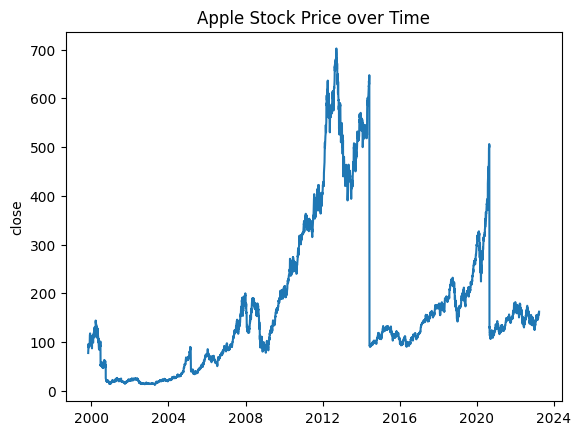

In [4]:
# Use only year format for x-axis
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year

# Perform EDA using Seaborn
sns.lineplot(data=df, x=df.index, y='close')
plt.title('Apple Stock Price over Time')
plt.show()

In [5]:
# Prepare the data
data = df.filter(['close']).values
train_len = int(len(data) * 0.8) # 80% for training

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

train_data = scaled_data[0:train_len, :]
x_train = []
y_train = []
win_size = 72
for i in range(win_size, len(train_data)):
    x_train.append(train_data[i-win_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the model
model = tf.keras.Sequential([
    layers.LSTM(units=32, return_sequences=True, input_shape=(win_size, 1)),
    layers.LSTM(units=32, return_sequences=True, dropout=.5),
    layers.LSTM(units=32, return_sequences=True, dropout=.5),
    layers.LSTM(units=32, dropout=.5),
    layers.Dense(units=32),
    layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1)
]

model.fit(x_train, y_train, batch_size=16, epochs=10, validation_split=0.3, callbacks=my_callbacks)

# Test the model
test_data = scaled_data[train_len - win_size:, :]
x_test = []
y_test = data[train_len:, :]
for i in range(win_size, len(test_data)):
    x_test.append(test_data[i-win_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate the model
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print('Root Mean Squared Error:', rmse)

Epoch 1/10
203/203 [==============================] - ETA: 0s - loss: 0.0039
Epoch 1: saving model to best_model.h5
203/203 [==============================] - 12s 44ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 2/10
203/203 [==============================] - ETA: 0s - loss: 0.0013
Epoch 2: saving model to best_model.h5
203/203 [==============================] - 8s 40ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 3/10
203/203 [==============================] - ETA: 0s - loss: 0.0011
Epoch 3: saving model to best_model.h5
203/203 [==============================] - 8s 40ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 4/10
203/203 [==============================] - ETA: 0s - loss: 0.0011
Epoch 4: saving model to best_model.h5
203/203 [==============================] - 8s 40ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 5/10
203/203 [==============================] - ETA: 0s - loss: 8.5154e-04
Epoch 5: saving model to best_model.h5
203/203 [==============================] - 10s 49ms/ste

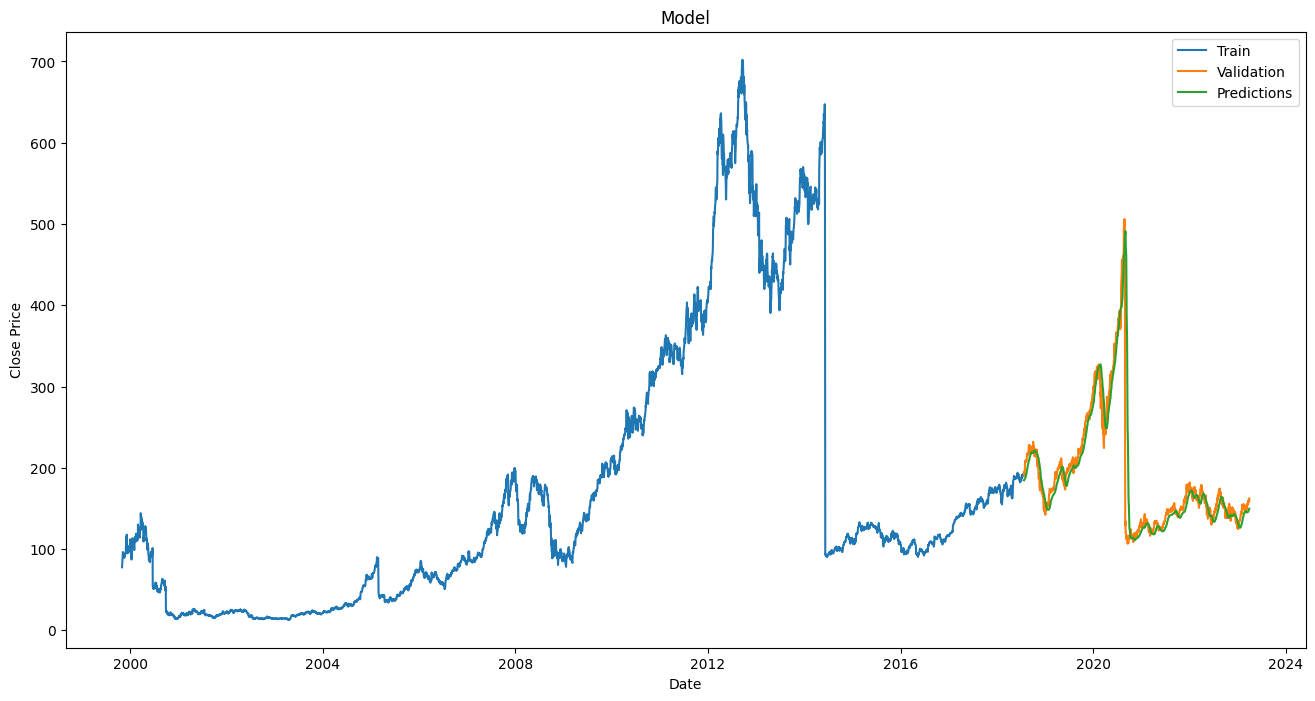

In [6]:
# Visualize the results
train = df.filter(['close'])[:train_len]
valid = df.filter(['close'])[train_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'])
plt.show()